# The Refinery Files 0x05: Flare On 9

This tutorial is a refinery-focused summary of my solutions for [FlareOn][] Vol.9. It will explore the reverse engineering of the individual challenges a bit more than other refinery tutorials might, to provide a more comprehensive summary of my CTF experience, but it still somewhat focused on using refinery, and at times I will simply tell you to [draw the rest of the fucking owl][Owl]. The code below is used for making this Jupyter notebook go brrr, you do not have to worry about it.

[FlareOn]: https://flare-on.com/
[Owl]: https://knowyourmeme.com/photos/572078-how-to-draw-an-owl

In [1]:
import tutorials.boilerplate

## Challenge 1 - Flaredle

In [1]:
%flare v09/01_flaredle.7z

02.826 kB 30009d0ce8b0128834fdebc5e00ffb8cdcdbfcab859f28eddadaf7073cc024c1 index.html
05.803 kB a7540fe262e8321f6127d63ee455b829f504a7f653e8b60b1b1ac9bff432fae8 script.js
00.885 kB 7ad6e01633afcce2620a251d12143ed1639de56afe80dd7e03e737e6aded271f style.css
04.613 kB 4168c7edd0ff76e5689babb2e310fc3560c57cae82101827d69594e28ae27a20 words.js


The challenge is modelled to be the nightmare version of [Wordle][], except that all the business logic is implemented in client-side JavaScript, so we can deduce the correct string from the source code:

[Wordle]: https://www.nytimes.com/games/wordle/index.html

In [1]:
%emit script.js | peek -d

------------------------------------------------------------------------------------------------------------------------
05.803 kB; 59.36% entropy; ASCII text, with CRLF line terminators
---------------------------------------------------------------------------------------------------------------[utf8]---
import { WORDS } from "./words.js";

const NUMBER_OF_GUESSES = 6;
const WORD_LENGTH = 21;
const CORRECT_GUESS = 57;
let guessesRemaining = NUMBER_OF_GUESSES;
let currentGuess = [];
let nextLetter = 0;
let rightGuessString = WORDS[CORRECT_GUESS];

------------------------------------------------------------------------------------------------------------------------


This looks a lot like we only need the word at index 57 from the array in `words.js`, and indeed that gives us the flag:

In [1]:
%emit words.js | carve -d string [| pick 57 ]]| cca @flare-on.com

flareonisallaboutcats@flare-on.com


## Challenge 2 - Pixel Poker

In [1]:
%flare v09/02_PixelPoker.7z

00.143 kB f143e358bae7fcdfa75586776f39e46ef5db924c6f117ededd55013cc00fabac readme.txt
02.931 MB 3e4c6409d75676f9a79a5392274bc459d2f75a6e2b6931a16dfa7187f3c65b36 PixelPoker.exe


When you run the file `PixelPoker.exe`, the executable shows an image that looks like color noise, i.e. a high entropy bitmap. I do not know exactly how the challenge was meant to be played, but the first thing I did was look for `BITMAP` resources in the sample file, and behold:

In [1]:
%emit PixelPoker.exe | perc BITMAP [| cfmt {size!r} {crc32} {path} ]]

01.426 MB 23f05b56 BITMAP/129/1033
01.426 MB d17f01d9 BITMAP/133/1033


There are *two* of them, not just one, and they both look like color noise. They also have the exact same size. What do we do with two BLOBs that have the exact same size and that look like high entropy noise? We XOR them together without even looking at any more code, and that'll already get you the flag:

In [1]:
%emit PixelPoker.exe | perc BITMAP -p [| put header cut::0x40 | pop k | xor eat:k | ccp eat:header | dump flag.bmp ]

This pipeline works as follows: First, use the [perc][] unit to extract all `BITMAP` PE resources from the sample. The `-p` switch adds artificial headers to the bitmap resources which are otherwise missing, only so we can more easily view them in an image viewer later. After that, we open a frame to process each of the two resources individually. First, we [put][] the first 64 bytes of each bitmap into a variable called `header`; note that the bytes are being removed from the input since we are using the `cut` handler. We are doing this because we want to preserve the header bytes and not have them be affected by the XOR operation that we are about to invoke. By the way, 64 bytes is _more_ than the actual bitmap header size, but I was too lazy to figure out the exact length and backing up few additional pixels from the actual bit map will not hurt us. After having backed up the bitmap header for each chunk, we can [pop][] one of the chunks into a variable named `k` and promptly [xor][] the other chunk with the contents of that variable. The `eat` handler works like the `var` handler and returns the contents of a meta variable, but `eat` also removes the variable after it has been used. Finally, we re-attach the header variable by using the [ccp][] unit and then [dump][] the result to a file called `flag.bmp`.


[perc]: https://binref.github.io/#refinery.perc
[put]: https://binref.github.io/#refinery.put
[pop]: https://binref.github.io/#refinery.pop
[dump]: https://binref.github.io/#refinery.dump
[ccp]: https://binref.github.io/#refinery.ccp
[xor]: https://binref.github.io/#refinery.xor

In [1]:
%ls

00.143 kB f143e358bae7fcdfa75586776f39e46ef5db924c6f117ededd55013cc00fabac readme.txt
02.931 MB 3e4c6409d75676f9a79a5392274bc459d2f75a6e2b6931a16dfa7187f3c65b36 PixelPoker.exe
01.426 MB 0a62ee83e837c1a7ff09789b420302574a3442304878fd86e0971077ac9dbf9e flag.bmp


Since IPython [does not currently support embedding bitmaps][IP9456], we have to quickly whip up a PNG conversion unit in refinery. We put the following code into a file called `topng.py` and make sure that our shell knows the command `binary-refinery`, and it points to the Python interpreter of a virtual environment that has refinery installed:

[IP9456]: https://github.com/ipython/ipython/issues/9456

In [1]:
#!binary-refinery
from refinery import Unit
from PIL import Image
from io import BytesIO

class topng(Unit):
    def process(self, data):
        with BytesIO(data) as stream:
            img = Image.open(stream)
            with BytesIO() as out:
                img.save(out, 'PNG')
                return out.getvalue()

Then, we can convert the final bitmap to a PNG file using this new unit:

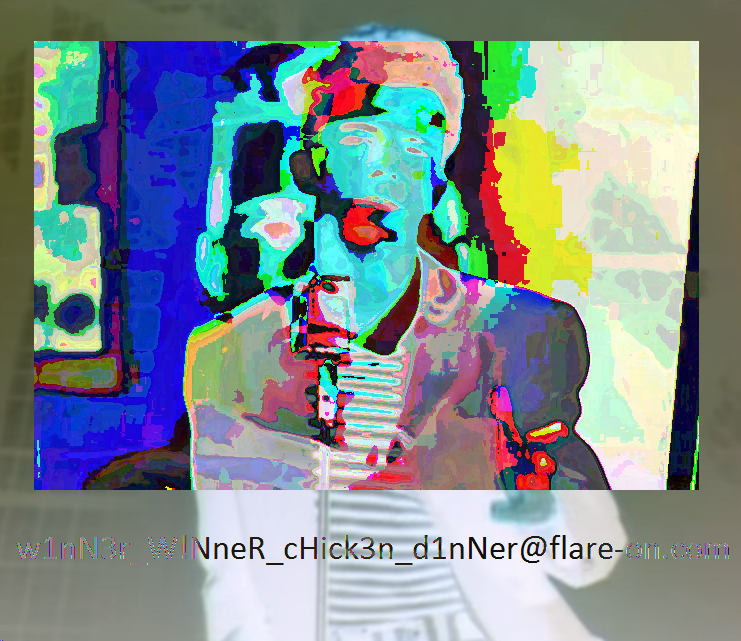

In [1]:
%emit flag.bmp | ./topng | dump flag.png
%show flag.png

This is, of course, not the intended way to solve the challenge. In fact, the image you see is the result of XOR-ing two images that have been XOR-encrypted with the same RC4-based key stream: Therefore, you are seeing the result of XOR-ing the two plaintext images together. The proper way to get the flag would be to reverse the code, implement the decryption, and then apply it. Like so:

In [1]:
#!binary-refinery
from refinery import Unit

from PIL import Image
from io import BytesIO
from Cryptodome.Cipher import ARC4

class fixel(Unit):
    def process(self, data):
        with BytesIO(data) as stream:
            image = Image.open(stream)
            width, height = image.size
            pixlz = image.load()
            for y in range(height):
                for x in range(width):
                    key = b'PixelPoker (%d,%d)' % (x, y)
                    pixlz[x, y] = tuple(ARC4.new(key).decrypt(bytes(pixlz[x, y])))
            with BytesIO() as out:
                image.save(out, 'PNG')
                return out.getvalue()

In [1]:
%emit PixelPoker.exe | perc 129 | ./fixel.py | dump flag.png

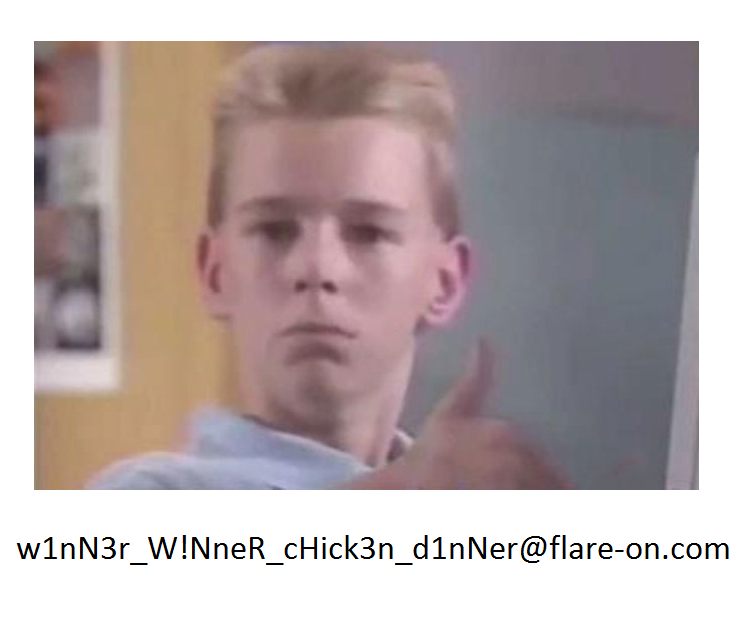

In [1]:
%show flag.png

Now, can you guess what the other image is?

## Challenge 3 - Magic 8 Ball

In [1]:
%flare v09/03_magic8ball.7z

18.574 kB 068f466d176b389cee73fa8b5db2e6412002ff5f39c9a3a2b10307603b0747d4 assets/ball_paint.png
00.190 MB 4e2371bc0e4cf6983342e150412f140da79d674c9be0b56458401f581072ecd3 assets/DroidSans.ttf
11.560 kB 3ddf9be5c28fe27dad143a5dc76eea25222ad1dd68934a047064e56ed2fa40c5 assets/LICENSE.txt
00.556 MB 4c8d67001d3c2977e5d6bf0a4f8add80cd564bd1df60b7569fd23751e7dda02a assets/NotoSans_Regular.ttf
04.449 kB 02f254589f3cc0e6b751faa152144b632041392b36dce0986dc1abf9d58ac21f assets/OFL.txt
00.130 MB 4c4241959ddb26f3931a9bd611886cfb614250dfc64ff30bd3ee891bc15b6113 assets/OpenSans_regular.ttf
00.224 MB d445efdd297e85576bad1e0fb8cebfd4868004c4544f87a2e958a9ecad48bd0c libjpeg-9.dll
00.199 MB 71dbd2b080df373b24b869900b96036fa3dd5b0295f5b074e8b27052d73c2794 libpng16-16.dll
00.429 MB 879c188f4d199384e1d752a3f07f6efcf5f2dca139605b19513642c16cb8f8e2 libtiff-5.dll
00.416 MB 49ff06a6aca781e9258d94262a61b3adfbecea80ace2d836911e330ecda926a0 libwebp-7.dll
20.992 kB 2fcead898d8f900715c9201f246d040eb9686b8f732e68351

After a few minutes spent reverse engineering the GUI setup, you should find the function at `0x004024e0`, which checks whether a certain string is equal to `LLURULDUL` before invoking the functions `0x00401220` and `0x00401a10`. The first of these looks like an `std::string` initialization, but I did not reverse engineer it in any detail. The second function, i.e. the one at `0x00401a10`, is a lot more interesting. It contains a stack string (instructions starting at `0x00401a62`) directly followed by a loop where the entries of a 256-element byte array are initialized to their index in the array. This screams [RC4][], and that's all we need to know:

[RC4]: https://en.wikipedia.org/wiki/RC4

In [1]:
%emit Magic8Ball.exe | vsnip 0x00401a62:110-3 | chop 10 [| snip 6: ]| rc4 LLURULDUL

U_cRackeD_th1$_maG1cBaLL_!!_@flare-on.com


## Challenge 4 - Darn Mice



_"If it crashes its user error."_  
â€ƒâ€ƒ-Flare Team

In [1]:
%flare v09/04_darn_mice.7z

00.103 MB 69300ed34608631e6704d04093001230772f047f8621940ce5f07a6099029f87 darn_mice.exe


This challenge definitely requires some reverse engineering. The main function calls a single routine at `0x00401000`, and this function receives the first command line parameter as its only argument. I named that parameter `keyphrase`. The following is the decompiled version of this function after some refactoring and cleaning up the stack string `check` for this notebook - it will never render that cleanly in Ghidra, or even IDA.
```c
void __cdecl FUN_00401000(char *keyphrase)
{
  size_t argument_length;
  uint k;
  code *page;
  unsigned char check[36] = {
    0x50,0x5e,0x5e,0xa3,0x4f,0x5b,0x51,0x5e,0x5e,0x97,
    0xa3,0x80,0x90,0xa3,0x80,0x90,0xa3,0x80,0x90,0xa3,
    0x80,0x90,0xa3,0x80,0x90,0xa3,0x80,0x90,0xa3,0x80,
    0x90,0xa2,0xa3,0x6b,0x7f,0
  };
  printf("On your plate, you see four olives.\n");
  argument_length = _strlen(keyphrase);
  if ((argument_length == 0) || (0x23 < argument_length)) {
    printf("No, nevermind.\n");
  }
  else {
    printf("You leave the room, and a mouse EATS one!\n");
    for (k = 0; ((k < 0x24 && (check[k] != '\0')) && (keyphrase[k] != '\0')); k += 1) {
      page = (code *)VirtualAlloc(NULL,0x1000,0x3000,0x40);
      *page = (code)(check[k] + keyphrase[k]);
      (*page)();
      printf("Nibble...\n");
    }
    printf("When you return, you only: %s\n",keyphrase,page);
    uc::decrypt_flag(FLAG_DATA,FLAG_SIZE,keyphrase,"salty",FLAG_DATA,FLAG_SIZE);
    printf("%s\n",FLAG_DATA);
  }
}
```
In the loop, the bytes of the `keyphrase` input string and the `check` array are added together, and then each of the resulting bytes is written to a new page and executed as a function. Now the only way this can really work without crashing is if we use that single byte to _immediately_ return from the horrible wasteland that is this newly allocated page. In other words, that single byte _always_ has to be `0xC3`, which encodes a `ret` instruction in x86 assembly. To recover the correct key phrase, we first need to get the contents of the `check` array out of the binary. The array is constructed by a sequence of 36 `mov` instructions starting at the virtual address `0x401025`, here is a peek at the disassembly: 

In [1]:
%emit darn_mice.exe | vsnip 0x401025:40 | asm

0000:  mov  byte ptr [ebp - 0x28], 0x50  ; C6 45 D8 50  .E.P
0004:  mov  byte ptr [ebp - 0x27], 0x5e  ; C6 45 D9 5E  .E.^
0008:  mov  byte ptr [ebp - 0x26], 0x5e  ; C6 45 DA 5E  .E.^
000C:  mov  byte ptr [ebp - 0x25], 0xa3  ; C6 45 DB A3  .E..
0010:  mov  byte ptr [ebp - 0x24], 0x4f  ; C6 45 DC 4F  .E.O
0014:  mov  byte ptr [ebp - 0x23], 0x5b  ; C6 45 DD 5B  .E.[
0018:  mov  byte ptr [ebp - 0x22], 0x51  ; C6 45 DE 51  .E.Q
001C:  mov  byte ptr [ebp - 0x21], 0x5e  ; C6 45 DF 5E  .E.^
0020:  mov  byte ptr [ebp - 0x20], 0x5e  ; C6 45 E0 5E  .E.^
0024:  mov  byte ptr [ebp - 0x1f], 0x97  ; C6 45 E1 97  .E..


Since the `mov` instructions always have the same length here, we can get the bytes as follows:

In [1]:
%emit darn_mice.exe | vsnip 0x401025:35*4 | snip 3::4 | hex -R

505E5EA34F5B515E5E97A38090A38090A38090A38090A38090A38090A38090A2A36B7F


Now we know that we want each byte of the passphrase to be exactly `0xC3-B`, where `B` is the current byte of the `check` array. We can use the [alu][] unit to make this computation, and get the correct key phrase:

[alu]: https://binref.github.io/#refinery.alu

In [1]:
%emit darn_mice.exe | vsnip 0x401025:35*4 | snip 3::4 | alu 0xC3-B

see three, C3 C3 C3 C3 C3 C3 C3! XD


Now that should be enough to get the flag out from the sample by simply running it with the correct input, but this wouldn't be a refinery tutorial if we didn't write a pipeline that extracts the flag completely statically:

In [1]:
%%emit darn_mice.exe [
    | push [
        | vsnip 0x401025:35*4
        | snip 3::4
        | alu 0xC3-B
        | pop k ]
    | vsnip 0x419000:0x2D
    | rc4 pbkdf2[64,salty,0x800,SHA512]:var:k ]

i_w0uld_l1k3_to_RETurn_this_joke@flare-on.com


Delightful. As far as the pipeline is concerned: We use [push][]/[pop][] as explained in earlier tutorials so that we can first use the previous pipeline to get the key and store it in a variable named `k`. Then, we get the encrypted flag data from the virtual address `0x419000`, it is `0x2D` characters in length. After briefly reversing the decryption function, you can figure out that the keyphrase is fed to a [pbkdf2][] key derivation function with the salt `salty`, `0x800` iterations, and using SHA512 as the hashing algorithm. And _naturally_, refinery can do all those things. No big deal.


[pbkdf2]: https://binref.github.io/#refinery.pbkdf2
[push]: https://binref.github.io/#refinery.push
[pop]: https://binref.github.io/#refinery.pop

## Challenge 5 - T8



In [1]:
%flare v09/05_t8.7z

03.904 kB 26381c3d80b9ac234938042640fb95d6683133910b98ddaeafa55ba837327f42 traffic.pcapng
00.342 MB 892a46d456d3ac2d4b406728b0b15dc40450c03bc40af03fd3c510f52eb6f3f7 t8.exe


This one is certainly more challenging than the previous ones. My approach was to simply reverse engineer the binary statically, which is also a good exercise in C++ reverse engineering: The classes are not complex and the interaction is straightforward. The fruits of your labor are a fairly solid understanding of how the traffic in the attached PCAP was generated.

Firstly, there is a global session key variable stored at `0x450870` whose value we require to decrypt the first response. It is initialized using the `rand` function in the function at `0x401020` which initializes several other global variables as well. Its value is inserted at the end of the user agent string in the first HTTP request that is made by the application, but not in the second. A flag argument to the HTTP request function controls whether or not the session key is sent. Its value, based on the PCAP data, is `11950` (look at the end of the first user agent string):

In [1]:
%emit traffic.pcapng | pcap [| rex -M User-Agent:(.*) {1} ]]

 Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.1; WOW64; Trident/4.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; .NET4.0C; .NET4.0E; 11950)
 Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.1; WOW64; Trident/4.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; .NET4.0C; .NET4.0E; CLR)


The actual session key is constructed as the concatenation of the string `FO` with the above decimal representation of the session key value, meaning `FO11950` is the session key for the first HTTP request. This session key is hashed using MD5, and the lowercase text representation of that hash in UTF-16 encoding is used as the key for an RC4 cipher to encrypt the first response:

In [1]:
%emit traffic.pcapng | pcap-http [| b64 | pick 0 | rc4 u16[-R]:md5[-t]:u:FO911950 | peek ]

------------------------------------------------------------------------------------------------------------------------
00.250 kB; 47.16% entropy; data
  url = http://flare-on.com/
------------------------------------------------------------------------------------------------------------------------
00000: E5 07 09 00 03 00 0F 00 0D 00 25 00 03 00 62 02 2C 00 DC 07 0A 00 06 00 0D 00 0D 00  ..........%...b.,...........
0001C: 25 00 09 00 2A 03 2C 00 E1 07 0C 00 04 00 07 00 0D 00 25 00 24 00 E5 00 2C 00 E0 07  %...*.,...........%.$...,...
00038: 05 00 05 00 06 00 0D 00 25 00 0B 00 26 00 2C 00 E2 07 0A 00 01 00 08 00 0D 00 25 00  ........%...&.,...........%.
00054: 1F 00 45 03 2C 00 E6 07 03 00 02 00 01 00 0D 00 25 00 32 00 DA 00 2C 00 DE 07 07 00  ..E.,...........%.2...,.....
00070: 02 00 16 00 0D 00 25 00 36 00 D1 02 2C 00 DE 07 05 00 03 00 0E 00 0D 00 25 00 01 00  ......%.6...,...........%...
0008C: E8 00 2C 00 DA 07 04 00 01 00 05 00 0D 00 25 00 3A 00 0B 00 2C 00 DD 07 0A 00 04 00  

Sadly, we are not done at this point. The data that comes from this first request is processed further by the sample to compute the main decryption key for the data to be retrieved with the second HTTP request. After some more reversing, we can establish that the format of the above data is as follows:

1. There are chunks of 16 bytes each, separated by a unicode string containing a single comma, which corresponds to the byte sequence `2C00`.
2. Each of these chunks is interpreted as a `SYSTEMTIME` structure.
3. From each `SYSTEMTIME` structure, the current moon phase is computed using the function at `0x404570`.
4. The values from the previous computation are interpreted as bytes to form the key.

Coincidentally, refinery does _not_ include a unit to compute moon phases, so we have to write a custom one:

In [1]:
#!binary-refinery
import struct
import math

from decimal import Decimal, ROUND_HALF_UP
from refinery import Unit

class moon(Unit):
    def process(self, data: bytearray):
        def roundf(t: float):
            x, _ = Decimal(t).to_integral_value(
                rounding=ROUND_HALF_UP).as_integer_ratio()
            return x
        y, m, _, d = struct.unpack('<HHHH', data[:8])
        if m < 3:
            m += 12
            y -= 1
        a = y // 100
        b = a // 4
        e = int(365.250 * (y + 4716.0))
        f = int(30.6001 * (m + 1))
        r = float(b + d + e + f - a + 2) - 1524.5 - 2451549.5
        r = r / 29.53
        q = math.floor(r)
        x = roundf((r - q) * 29.53)
        x = B' abcdefghijklmnopqrstuvwxyz0_3'[x:x + 1]
        return x

Armed with this moon phase unit, we can compute the flag:

In [1]:
%%emit traffic.pcapng | pcap-http [
    | b64 | pick 0 | rc4 u16[-R]:md5[-t]:u:FO911950 | resplit h:2C00 [| ./moon.py -v ]
    | cca @flare-on.com ]

i_s33_you_m00n@flare-on.com


This will already solve the challenge, but I really didn't feel comfortable stopping until I also had the actual payload:

In [1]:
%%emit traffic.pcapng
    | pcap-http [
        | b64
        | scope 0
        | rc4 u16[-R]:md5[-t]:u:FO911950
        | resplit h:2C00 [| ./moon.py -v ]
        | cca @flare-on.com
        | pop key:u16[-R]:md5[-t]:u16[-R]
        | rc4 var:key ]
    | asm

0000:  xor   edx, edx                          ; 31 D2                 1.     
0002:  mov   dl, 0x30                          ; B2 30                 .0     
0004:  mov   edx, dword ptr fs:[edx]           ; 64 8B 12              d..    
0007:  mov   edx, dword ptr [edx + 0xc]        ; 8B 52 0C              .R.    
000A:  mov   edx, dword ptr [edx + 0x1c]       ; 8B 52 1C              .R.    
000D:  mov   eax, dword ptr [edx + 8]          ; 8B 42 08              .B.    
0010:  mov   esi, dword ptr [edx + 0x20]       ; 8B 72 20              .r.    
0013:  mov   edx, dword ptr [edx]              ; 8B 12                 ..     
0015:  cmp   byte ptr [esi + 0xc], 0x33        ; 80 7E 0C 33           .~.3   
0019:  jne   0xd                               ; 75 F2                 u.     
001B:  mov   edi, eax                          ; 89 C7                 ..     
001D:  add   edi, dword ptr [eax + 0x3c]       ; 03 78 3C              .x<    
0020:  mov   edx, dword ptr [edi + 0x78]       ; 8B 

In case you're wondering, it does some API resolution and then calls:
```c
FatalAppExitA("You're a machine!!!")
```

## Challenge 6 - A La Mode

In [1]:
%flare v09/06_alamode.7z

00.266 kB 9c5f7abec18d7980875e7958cde8f9965b25f9e6c1322dc5145dbb34548ef3b8 IR chat log.txt
78.848 kB 52692c449b875860267cb876f2e8a3e57f0d4a5e2b72e4a99126ea2be853268f HowDoesThisWork.dll


The file `HowDoesThisWork.dll` is a .NET PE, and decompiling it using [dnSpyEx][] or [ILSpy][] produces very clean but useless code:
```csharp
using System;
using System.IO.Pipes;
using System.Text;

public string GetFlag(string password)
{
    Decoder decoder = Encoding.UTF8.GetDecoder();
    UTF8Encoding uTF8Encoding = new UTF8Encoding();
    string text = "";
    byte[] array = new byte[64];
    char[] array2 = new char[64];
    byte[] bytes = uTF8Encoding.GetBytes(password + "\0");
    using (NamedPipeClientStream namedPipeClientStream 
        = new NamedPipeClientStream(".", "FlareOn", PipeDirection.InOut))
    {
        namedPipeClientStream.Connect();
        namedPipeClientStream.ReadMode = PipeTransmissionMode.Message;
        namedPipeClientStream.Write(bytes, 0, Math.Min(bytes.Length, 64));
        int byteCount = namedPipeClientStream.Read(array, 0, array.Length);
        int chars = decoder.GetChars(array, 0, byteCount, array2, 0);
        text += new string(array2, 0, chars);
    }
    return text;
}
```
It wants to read the flag from a named pipe, but we don't know who or what provided that named pipe, let alone the flag that should be sent over it. The IR chat log file shows that the FLARE Team was facing a similar issue:

[ILSpy]: https://github.com/icsharpcode/ILSpy
[dnSpyEx]: https://github.com/dnSpyEx/dnSpy

In [1]:
%emit "IR chat log.txt"

[FLARE Team]  Hey IR Team, it looks like this sample has some other binary that might 
              interact with it, do you have any other files that might be of help.
			  
[IR Team]     Nope, sorry this is all we got from the client, let us know what you got.


Time to get cracking! I immediately had a strong suspicion based on the above hints that this could be a mixed mode .NET binary, so I had a quick look at its metadata:

In [1]:
%emit HowDoesThisWork.dll | pemeta -t [| iffs DotNet ]]

DotNet.RuntimeVersion : 2.5
DotNet.Version        : 1.1
DotNet.VersionString  : v4.0.30319
DotNet.Flags[0x0]     : NATIVE_ENTRYPOINT
DotNet.AssemblyName   : FlareOn_x86
DotNet.Release        : 0.0.0.0
DotNet.EntryPoint     : 0x1000181A
DotNet.ModuleName     : FlareOn_x86.dll


As suspected, the `NATIVE_ENTRYPOINT` flag is set for this executable. Also, refinery tells us that said entry point will be at `0x1000181A`. Time to fire up your favourite disassembler & decompiler and have a look at what is going on in there! Regardless of what you use, however, make sure to open the file as a native PE binary, even if your toolkit's first impulse is to open it as a .NET Assembly.

First, I reversed the string encryption function at `0x100014ae` and decrypted the strings in the function `0x100012f1`. The string encryption function is a simple XOR with `0x17` and I used Ghidra's [XorMemoryScript][] to decrypt the global variables. I then removed the writable flag from the `.data` section to make string literals show up in the pseudo code. Finally, I assumed from the strings that the function at `0x1000125c` performs dynamic API resolution and renamed the global variables to the corresponding API symbol name. After that, the API resolution function looks as follows:
```c
void FUN_100012f1(void)
{
  IMAGE_DOS_HEADER *module;
  int name;
  
  memset = memset;
  strcmp = strcmp;
  memcpy = memcpy;
  module = (IMAGE_DOS_HEADER *)kernel32();
  name = string_decrypt("CloseHandle\n",&_TMP);
  CloseHandle = (CloseHandle *)resolve_api(module,name);
  name = string_decrypt("ConnectNamedPipe",&_TMP);
  ConnectNamedPipe = (ConnectNamedPipe *)resolve_api(module,name);
  name = string_decrypt("CreateNamedPipeA",&_TMP);
  CreateNamedPipeA = (CreateNamedPipeA *)resolve_api(module,name);
  name = string_decrypt("CreateThread",&_TMP);
  CreateThread = (CreateThread *)resolve_api(module,name);
  name = string_decrypt("DisconnectNamedPipe",&_TMP);
  DisconnectNamedPipe = (DisconnectNamedPipe *)resolve_api(module,name);
  name = string_decrypt("FlushFileBuffers",&_TMP);
  FlushFileBuffers = (FlushFileBuffers *)resolve_api(module,name);
  name = string_decrypt("GetLastError",&_TMP);
  GetLastError = (GetLastError *)resolve_api(module,name);
  name = string_decrypt("GetProcessHeap",&_TMP);
  GetProcessHeap = (GetProcessHeap *)resolve_api(module,name);
  name = string_decrypt("lstrcmpA",&_TMP);
  lstrcmpA = (lstrcmpA *)resolve_api(module,name);
  name = string_decrypt("ReadFile",&_TMP);
  ReadFile = (ReadFile *)resolve_api(module,name);
  name = string_decrypt("WriteFile",&_TMP);
  WriteFile = (WriteFile *)resolve_api(module,name);
  return;
}
```
I am not sure what is going on with that line break character after `CloseHandle`. Anyway, with API names resolved, it is easy to figure out what is going on next:
```c
undefined4 FUN_10001163(undefined4 param_1,int param_2)
{
  if (param_2 == 1) {
    FUN_100012f1();
    (*CreateThread)(NULL,0,FUN_10001094,NULL,0,NULL);
  }
  return 1;
}
```
It creates a new thread with entry point `0x10001094`. That function opens the pipe `\\.\pipe\FlareOn` and sends something to it, something that is produced by the function at `0x10001000`. This function looked as follows after I was done reversing it in Ghidra:
```c
bool __cdecl FUN_10001000(LPCSTR password,undefined4 *out_size)
{
  int cmp;
  char *out_data;
  rc4_t cipher;
  
  rc4::setup(&cipher,&KEY,8);
  rc4::crypt(&cipher,&CHECK,9);
  cmp = (*lstrcmpA)(&CHECK,password);
  if (cmp == 0) {
    out_data = &FLAG;
    rc4::crypt(&cipher,&FLAG,0x1f);
    *out_size = 0x1f;
  }
  else {
    *out_size = 0x15;
    out_data = uc::string_decrypt("Authorization Failed","");
  }
  (*memcpy)(password,out_data);
  return cmp == 0;
}
```
The `rc4_t` class maintains state, so we have to feed it all the data in the correct order to get the flag out. The global variables `KEY`, `FLAG`, and `CHECK` are laid out in memory in that exact order, so we have to shuffle everything around a bit:

[XorMemoryScript]: https://github.com/NationalSecurityAgency/ghidra/blob/master/Ghidra/Features/Base/ghidra_scripts/XorMemoryScript.java

In [1]:
%emit HowDoesThisWork.dll | vsnip 0x10015000 [| struct {k:8}{:32}{:9} {3}{2} | rc4 eat:k | snip 9: | terminate ]

M1x3d_M0dE_4_l1f3@flare-on.com


An easy way to get the bytes in the right order is the [struct][] unit, which in the above pipeline extracts 8 bytes into a variable named `k`, then 32 bytes for the flag and 9 bytes for the password check. It then outputs the 3rd and 2nd chunk (password check and flag) in reverse order because this is the order in which the program feeds that data to the RC4 cipher. Finally, we use [rc4][] to decrypt both the check string and the flag. We use [snip][] to remove the bytes of the check string again and [terminate][] to clip everything after the terminating null byte. Voila!

[struct]: https://binref.github.io/#refinery.struct
[rc4]: https://binref.github.io/#refinery.rc4
[snip]: https://binref.github.io/#refinery.snip
[terminate]: https://binref.github.io/#refinery.terminate

## Challenge 7 - ANode

This was one of the more difficult challenges in my opinion, but mostly because it was a lot of work. Refinery played no part in solving it, so I will only sketch the solution here.

It is a Node.js application, and I did not reverse engineer the binary part - I made my way through by patching and analyzing the script body attached at the end. First, I patched the code to do two things for me:

- dump the first 10.000 results of the "random" number generator
- dump the expected sequence of states for the large switch statement

With the patches, I ran the binary with any input that has the correct length just to make it go through the motions. Armed with this information, I was also able to port the JavaScript code to a Python script. I used the dumped PRNG values to implement a mock version that generated the same values. Next, I generated a dictionary that mapped each state to a boolean value indicating which branch of its if-else statement (when present) is taken. I did this by re-running the sequence in an endless loop and adjusting my branch prediction until the observed sequence of state values was exactly the same as the one I had dumped from `anode.exe`. 

With the branch prediction done, I could start solving the system of equations. For this, I iterated over the states in reverse order and used [Z3][] to construct a solution for the equations that are applied in each step of the state machine. The script runs for a few seconds and then produces the flag:
```
n0t_ju5t_A_j4vaSCriP7_ch4l1eng3@flare-on.com
```

[Z3]: https://github.com/Z3Prover/z3

## Challenge 8 - Backdoor

In [1]:
%flare v09/08_backdoor.7z

11.611 MB 9eed8f763aa1bb478223721cbf48acbe68e501275f604f634b008f3a492ae3c1 FlareOn.Backdoor.exe


This one was really easy, you just have to know the right section name and RC4 key:

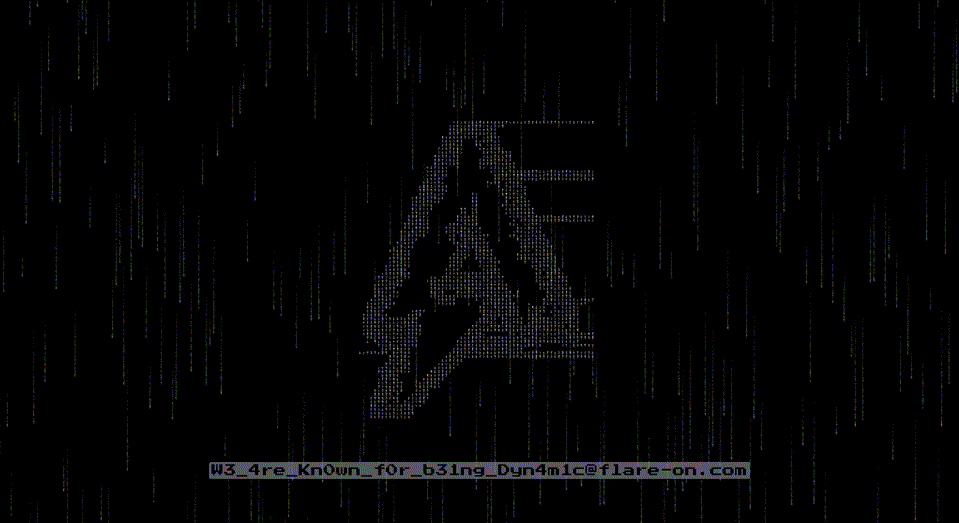

In [1]:
%emit FlareOn.Backdoor.exe | vsect 5aeb2b97 | rc4 h:944cee4d42583a53e81a7ea5c9dc2bb6b901213a0eb3286ca69d3f01ef84acbb | ./topng | dump flag.png
%show flag.png

Ok, I am kidding. This was the hardest challenge for me and it took several days to complete. However, while the FLARE team might be known for being dynamic, I am known for being extremely _static_. In retrospective, I am not sure whether that was a clever choice for this challenge.

I decided to write a [custom deobfuscator for the binary][deobfuscator]. This was the first time I wrote anything even half serious in C#, so setting up the environment and understanding the ecosystem was half the trouble for me, but I already knew that the best .NET deobfuscators were written in .NET-ish languages. For the library, I decided to use [AsmResolver][] because I had heard many good things about it from @[dr4k0nia][], who is my personal role model in .NET reversing and deobfuscation. I am also indebted tremendously to @[Washi][] who took the time to answer all my questions about [AsmResolver][].

My journey to the flag consisted of two layers of obfuscation and the key computation, each of which will be treated in a separate subsection.


[AsmResolver]: https://github.com/Washi1337/AsmResolver
[dr4k0nia]: https://twitter.com/dr4k0nia
[Washi]: https://twitter.com/washi_dev
[deobfuscator]: https://github.com/huettenhain/flareon9

### Deobufscation Phase 1

The first pattern we observe is the following:
```csharp
public static void flare_37(string f)
{
    try
    {
        FLARE09.flared_35(f);
    }
    catch (InvalidProgramException ex)
    {
        FLARE15.flare_71(ex, new object[] { f }, FLARE15.pe_m, FLARE15.pe_b);
    }
}
```
When the function `flare_37` is invoked, it will attempt to act as a proxy for `flared_35`. The instructions of `flared_35` are invalid and an `InvalidProgramException` is raised. Upon catching that exception, the function calls `flare_71` passing the exception object, an array containing all function parameters, and two additional pieces of data, `m` and `b`. The variable `b` contains the IL instructions to be executed, and `m` is a dictionary mapping offsets in the byte code to token values. The function `flare_71` uses the exception object `ex` to obtain information about return type, parameter types, and local variables from the function that raised it. It then creates a dynamic method that inherits all these properties, but uses the opcodes in `b`. It also patches all tokens in the IL code with values that work inside the context of that dynamic method. Finally, this dynamic method is invoked with the given parameters.

To fix this part of the obfuscation, I copied the dictionaries `m` and the byte arrays `b` from `FLARE15.flare_74` into [my own class][obfu1] and wrote methods `GetB` and `GetM` to access them. For example, `GetB("pe")` would return the variable `pe_b` that contains the unpatched opcodes for `flared_35`. The code that deobfuscates these methods can be found [here][deobfu1].

[obfu1]: https://github.com/huettenhain/flareon9/blob/main/FlareObfu1.cs
[deobfu1]: https://github.com/huettenhain/flareon9/blob/main/Program.cs#L254

## Deobfuscation Phase 2

For the second phase of the obfuscation, it is necessary to have finished the previous step and written the module back to disk. The second pattern for obfuscated functions is similar to the first, here is an example:
```csharp
public static FLARE07 flare_72()
{
    FLARE07 flare;
    try
    {
        flare = Program.flared_39();
    }
    catch (InvalidProgramException ex)
    {
        flare = (FLARE07)FLARE15.flare_70(ex, null);
    }
    return flare;
}
```
The business logic of `flare_70` is implemented in the now deobfuscated `flared_70`:
```csharp
public static object flared_70(InvalidProgramException e, object[] a)
{
    StackTrace stackTrace = new StackTrace(e);
    int metadataToken = stackTrace.GetFrame(0).GetMethod().MetadataToken;
    string text = FLARE15.flare_66(metadataToken);
    byte[] array = FLARE15.flare_69(text);
    byte[] array2 = FLARE12.flare_46(new byte[] { 18, 120, 171, 223 }, array);
    return FLARE15.flare_67(array2, metadataToken, a);
}
```
The function `flare_66` computes a SHA-256 hash from several metadata of the function that raised the `InvalidProgramException`. It returns the lowercase hexadecimal representation of that hash. The function `flare_69` then finds a PE section whose name is the start of the hash string and returns its contents. The function `flare_46` is just RC4 encryption with a hard-coded key. The result of this decryption are the opcodes for the deobfuscated method, and `flare_67` is very similar to `flare_71`: It fixes the IL code to work inside a dynamic method. The code to undo this part of the obfuscation can be found [here][deobfu2].

I had some problems where I am probably computing the wrong hash, but I don't exactly know why - however, I noticed that the size of each section containing obfuscated code was the same as the size of the function in the binary that it replaced. Based on this, I was able to [map the remaining sections to functions as well][deobfu3].

[deobfu2]: https://github.com/huettenhain/flareon9/blob/main/Program.cs#L223
[deobfu3]: https://github.com/huettenhain/flareon9/blob/main/Program.cs#L271

## Key Computation

After having deobfuscated the binary, you still have to reverse engineer it. The main hint for me was the one section named `5aeb2b97` that remained after converting all other weirdly named sections back to code; this section also sticks out tremendously in terms of size:

In [1]:
%emit FlareOn.Backdoor.exe | vsect [| sorted size | pick :5 | cfmt {size!r} {path} ]]

11.422 MB 5aeb2b97
00.109 MB .text
03.584 kB 8a966e19
01.536 kB .l2
01.536 kB .rsrc


Since the section name is a lowercase hex string as well, I searched for other references to method `flare_69`, the one that is used to look up a section from a SHA-256 hash during the second deobfuscation layer. And indeed, there is another function that calls it:
```csharp
public static void flared_54()
{
    byte[] array = FLARE15.flare_69(FLARE14.flare_54(FLARE14.sh));
    byte[] hashAndReset = FLARE14.h.GetHashAndReset();
    byte[] array2 = FLARE12.flare_46(hashAndReset, array);
    string text = Path.GetTempFileName() + Encoding.UTF8.GetString(FLARE12.flare_46(hashAndReset, new byte[] { 31, 29, 40, 72 }));
    FileStream fileStream = new FileStream(text, FileMode.Create, FileAccess.Write, FileShare.Read);
    fileStream.Write(array2, 0, array2.Length);
    Process.Start(text);
}
```
From there, it is a matter of following up where `FLARE14.sh` and `FLARE14.h` are being updated. This leads you to the command handler `flared_56`. When a command is received, it calls `flare_56` with an integer and a hexadecimal string to be appended to `FLARE14.sh`. That function checks whether the integer is the correct one in a pre-defined sequence of integers: The constant `FLARE15.c` contains this sequence, XOR-ed with `248`. From this sequence, you can therefore deduce the correct order of the commands and how they contribute to the value `FLARE14.h`, which we will need to decrypt the flag. In the command handler, this hash is always updated in the following manner:
```csharp
    FLARE14.h.AppendData(Encoding.ASCII.GetBytes(FLARE14.flare_57() + text2));
```
The `text2` variable here is something that is right in front of you in the code, but the return value of `FLARE14.flare_57` is more difficult to obtain:
```csharp
public static string flared_57()
{
    StackTrace stackTrace = new StackTrace();
    return stackTrace.GetFrame(1).GetMethod().ToString() + stackTrace.GetFrame(2).GetMethod().ToString();
}

public static string flare_57()
{
    string text;
    try
    {
        text = FLARE14.flared_57();
    }
    catch (InvalidProgramException ex)
    {
        text = (string)FLARE15.flare_70(ex, null);
    }
    return text;
}
```
While this looks annoying, it is also clear that the return value of `flared_57` will always be the same, since we are only interested in calls to this function that originate from `flared_56`. Hence, a very easy way to get the value is to simply debug the executable in [dnSpyEx][] and obtain the return value by calling `flared_57` from a variable watch window. This can even be done with the still obfuscated binary in case your deobfuscated binary does not execute. Ultimately, I ended up with the following Python script for computing the key:

[dnSpyEx]: https://github.com/dnSpyEx/dnSpy

In [1]:
import hashlib

magic = (
    b"System.Object InvokeMethod(System.Object, System.Object[], System.Signature, Boolean)"
    b"System.Object Invoke(System.Object, System.Reflection.BindingFlags, System.Reflection"
    b".Binder, System.Object[], System.Globalization.CultureInfo)"
)

def make_powershell_command(t: str) -> bytes:
    return B'powershell -exec bypass -enc "' + t.encode('latin1') + b'"'

chunks = [
    make_powershell_command(
        "RwBlAHQALQBOAGUAdABOAGUAaQBnAGgAYgBvAHIAIAAtAEEAZABkAHIAZQBzAHMARgBhAG0AaQBsAHkA"
        "IABJAFAAdgA0ACAAfAAgAFMAZQBsAGUAYwB0AC0ATwBiAGoAZQBjAHQAIAAiAEkAUABBAEQARAByAGUA"
        "cwBzACIA"),
    b'hostname',
    make_powershell_command(
        "RwBlAHQALQBDAGgAaQBsAGQASQB0AGUAbQAgAC0AUABhAHQAaAAgACcAQwA6AFwAUAByAG8AZwByAGEA"
        "bQAgAEYAaQBsAGUAcwAgACgAeAA4ADYAKQAnACAAfAAgAFMAZQBsAGUAYwB0AC0ATwBiAGoAZQBjAHQA"
        "IABOAGEAbQBlAA=="),
    make_powershell_command(
        "JChwaW5nIC1uIDEgMTAuNjUuNDUuMyB8IGZpbmRzdHIgL2kgdHRsKSAtZXEgJG51bGw7JChwaW5nIC1u"
        "IDEgMTAuNjUuNC41MiB8IGZpbmRzdHIgL2kgdHRsKSAtZXEgJG51bGw7JChwaW5nIC1uIDEgMTAuNjUu"
        "MzEuMTU1IHwgZmluZHN0ciAvaSB0dGwpIC1lcSAkbnVsbDskKHBpbmcgLW4gMSBmbGFyZS1vbi5jb20g"
        "fCBmaW5kc3RyIC9pIHR0bCkgLWVxICRudWxs"),
    make_powershell_command(
        "RwBlAHQALQBOAGUAdABUAEMAUABDAG8AbgBuAGUAYwB0AGkAbwBuACAAfAAgAFcAaABlAHIAZQAtAE8A"
        "YgBqAGUAYwB0ACAAewAkAF8ALgBTAHQAYQB0AGUAIAAtAGUAcQAgACIARQBzAHQAYQBiAGwAaQBzAGgA"
        "ZQBkACIAfQAgAHwAIABTAGUAbABlAGMAdAAtAE8AYgBqAGUAYwB0ACAAIgBMAG8AYwBhAGwAQQBkAGQA"
        "cgBlAHMAcwAiACwAIAAiAEwAbwBjAGEAbABQAG8AcgB0ACIALAAgACIAUgBlAG0AbwB0AGUAQQBkAGQA"
        "cgBlAHMAcwAiACwAIAAiAFIAZQBtAG8AdABlAFAAbwByAHQAIgA="),
    make_powershell_command(
        "RwBlAHQALQBOAGUAdABJAFAAQQBkAGQAcgBlAHMAcwAgAC0AQQBkAGQAcgBlAHMAcwBGAGEAbQBpAGwA"
        "eQAgAEkAUAB2ADQAIAB8ACAAUwBlAGwAZQBjAHQALQBPAGIAagBlAGMAdAAgAEkAUABBAGQAZAByAGUA"
        "cwBzAA=="),
    make_powershell_command(
        "JAAoAHAAaQBuAGcAIAAtAG4AIAAxACAAMQAwAC4AMQAwAC4AMQAwAC4ANAAgAHwAIABmAGkAbgBkAHMA"
        "dAByACAALwBpACAAdAB0AGwAKQAgAC0AZQBxACAAJABuAHUAbABsADsAJAAoAHAAaQBuAGcAIAAtAG4A"
        "IAAxACAAMQAwAC4AMQAwAC4ANQAwAC4AMQAwACAAfAAgAGYAaQBuAGQAcwB0AHIAIAAvAGkAIAB0AHQA"
        "bAApACAALQBlAHEAIAAkAG4AdQBsAGwAOwAkACgAcABpAG4AZwAgAC0AbgAgADEAIAAxADAALgAxADAA"
        "LgAyADIALgA1ADAAIAB8ACAAZgBpAG4AZABzAHQAcgAgAC8AaQAgAHQAdABsACkAIAAtAGUAcQAgACQA"
        "bgB1AGwAbAA7ACQAKABwAGkAbgBnACAALQBuACAAMQAgADEAMAAuADEAMAAuADQANQAuADEAOQAgAHwA"
        "IABmAGkAbgBkAHMAdAByACAALwBpACAAdAB0AGwAKQAgAC0AZQBxACAAJABuAHUAbABsAA=="),
    make_powershell_command(
        "bnNsb29rdXAgZmxhcmUtb24uY29tIHwgZmluZHN0ciAvaSBBZGRyZXNzO25zbG9va3VwIHdlYm1haWwu"
        "ZmxhcmUtb24uY29tIHwgZmluZHN0ciAvaSBBZGRyZXNz"),
    b"systeminfo | findstr /i \"Domain\"",
    make_powershell_command(
        "JAAoAHAAaQBuAGcAIAAtAG4AIAAxACAAMQAwAC4ANgA1AC4ANQAxAC4AMQAxACAAfAAgAGYAaQBuAGQA"
        "cwB0AHIAIAAvAGkAIAB0AHQAbAApACAALQBlAHEAIAAkAG4AdQBsAGwAOwAkACgAcABpAG4AZwAgAC0A"
        "bgAgADEAIAAxADAALgA2ADUALgA2AC4AMQAgAHwAIABmAGkAbgBkAHMAdAByACAALwBpACAAdAB0AGwA"
        "KQAgAC0AZQBxACAAJABuAHUAbABsADsAJAAoAHAAaQBuAGcAIAAtAG4AIAAxACAAMQAwAC4ANgA1AC4A"
        "NQAyAC4AMgAwADAAIAB8ACAAZgBpAG4AZABzAHQAcgAgAC8AaQAgAHQAdABsACkAIAAtAGUAcQAgACQA"
        "bgB1AGwAbAA7ACQAKABwAGkAbgBnACAALQBuACAAMQAgADEAMAAuADYANQAuADYALgAzACAAfAAgAGYA"
        "aQBuAGQAcwB0AHIAIAAvAGkAIAB0AHQAbAApACAALQBlAHEAIAAkAG4AdQBsAGwA"),
    b"net user",
    make_powershell_command(
        "JAAoAHAAaQBuAGcAIAAtAG4AIAAxACAAMQAwAC4ANgA1AC4ANAAuADUAMAAgAHwAIABmAGkAbgBkAHMA"
        "dAByACAALwBpACAAdAB0AGwAKQAgAC0AZQBxACAAJABuAHUAbABsADsAJAAoAHAAaQBuAGcAIAAtAG4A"
        "IAAxACAAMQAwAC4ANgA1AC4ANAAuADUAMQAgAHwAIABmAGkAbgBkAHMAdAByACAALwBpACAAdAB0AGwA"
        "KQAgAC0AZQBxACAAJABuAHUAbABsADsAJAAoAHAAaQBuAGcAIAAtAG4AIAAxACAAMQAwAC4ANgA1AC4A"
        "NgA1AC4ANgA1ACAAfAAgAGYAaQBuAGQAcwB0AHIAIAAvAGkAIAB0AHQAbAApACAALQBlAHEAIAAkAG4A"
        "dQBsAGwAOwAkACgAcABpAG4AZwAgAC0AbgAgADEAIAAxADAALgA2ADUALgA1ADMALgA1ADMAIAB8ACAA"
        "ZgBpAG4AZABzAHQAcgAgAC8AaQAgAHQAdABsACkAIAAtAGUAcQAgACQAbgB1AGwAbAA7ACQAKABwAGkA"
        "bgBnACAALQBuACAAMQAgADEAMAAuADYANQAuADIAMQAuADIAMAAwACAAfAAgAGYAaQBuAGQAcwB0AHIA"
        "IAAvAGkAIAB0AHQAbAApACAALQBlAHEAIAAkAG4AdQBsAGwA"),
    make_powershell_command(
        "RwBlAHQALQBEAG4AcwBDAGwAaQBlAG4AdABTAGUAcgB2AGUAcgBBAGQAZAByAGUAcwBzACAALQBBAGQA"
        "ZAByAGUAcwBzAEYAYQBtAGkAbAB5ACAASQBQAHYANAAgAHwAIABTAGUAbABlAGMAdAAtAE8AYgBqAGUA"
        "YwB0ACAAUwBFAFIAVgBFAFIAQQBkAGQAcgBlAHMAcwBlAHMA"),
    b"whoami",
    make_powershell_command(
        "JAAoAHAAaQBuAGcAIAAtAG4AIAAxACAAMQAwAC4AMQAwAC4AMgAyAC4ANAAyACAAfAAgAGYAaQBuAGQA"
        "cwB0AHIAIAAvAGkAIAB0AHQAbAApACAALQBlAHEAIAAkAG4AdQBsAGwAOwAkACgAcABpAG4AZwAgAC0A"
        "bgAgADEAIAAxADAALgAxADAALgAyADMALgAyADAAMAAgAHwAIABmAGkAbgBkAHMAdAByACAALwBpACAA"
        "dAB0AGwAKQAgAC0AZQBxACAAJABuAHUAbABsADsAJAAoAHAAaQBuAGcAIAAtAG4AIAAxACAAMQAwAC4A"
        "MQAwAC4ANAA1AC4AMQA5ACAAfAAgAGYAaQBuAGQAcwB0AHIAIAAvAGkAIAB0AHQAbAApACAALQBlAHEA"
        "IAAkAG4AdQBsAGwAOwAkACgAcABpAG4AZwAgAC0AbgAgADEAIAAxADAALgAxADAALgAxADkALgA1ADAA"
        "IAB8ACAAZgBpAG4AZABzAHQAcgAgAC8AaQAgAHQAdABsACkAIAAtAGUAcQAgACQAbgB1AGwAbAA="),
    make_powershell_command(
        "JAAoAHAAaQBuAGcAIAAtAG4AIAAxACAAMQAwAC4ANgA1AC4ANAA1AC4AMQA4ACAAfAAgAGYAaQBuAGQA"
        "cwB0AHIAIAAvAGkAIAB0AHQAbAApACAALQBlAHEAIAAkAG4AdQBsAGwAOwAkACgAcABpAG4AZwAgAC0A"
        "bgAgADEAIAAxADAALgA2ADUALgAyADgALgA0ADEAIAB8ACAAZgBpAG4AZABzAHQAcgAgAC8AaQAgAHQA"
        "dABsACkAIAAtAGUAcQAgACQAbgB1AGwAbAA7ACQAKABwAGkAbgBnACAALQBuACAAMQAgADEAMAAuADYA"
        "NQAuADMANgAuADEAMwAgAHwAIABmAGkAbgBkAHMAdAByACAALwBpACAAdAB0AGwAKQAgAC0AZQBxACAA"
        "JABuAHUAbABsADsAJAAoAHAAaQBuAGcAIAAtAG4AIAAxACAAMQAwAC4ANgA1AC4ANQAxAC4AMQAwACAA"
        "fAAgAGYAaQBuAGQAcwB0AHIAIAAvAGkAIAB0AHQAbAApACAALQBlAHEAIAAkAG4AdQBsAGwA"),
    make_powershell_command(
        "RwBlAHQALQBOAGUAdABJAFAAQwBvAG4AZgBpAGcAdQByAGEAdABpAG8AbgAgAHwAIABGAG8AcgBlAGEA"
        "YwBoACAASQBQAHYANABEAGUAZgBhAHUAbAB0AEcAYQB0AGUAdwBhAHkAIAB8ACAAUwBlAGwAZQBjAHQA"
        "LQBPAGIAagBlAGMAdAAgAE4AZQB4AHQASABvAHAA"),
    make_powershell_command(
        "JAAoAHAAaQBuAGcAIAAtAG4AIAAxACAAMQAwAC4AMQAwAC4AMgAxAC4AMgAwADEAIAB8ACAAZgBpAG4A"
        "ZABzAHQAcgAgAC8AaQAgAHQAdABsACkAIAAtAGUAcQAgACQAbgB1AGwAbAA7ACQAKABwAGkAbgBnACAA"
        "LQBuACAAMQAgADEAMAAuADEAMAAuADEAOQAuADIAMAAxACAAfAAgAGYAaQBuAGQAcwB0AHIAIAAvAGkA"
        "IAB0AHQAbAApACAALQBlAHEAIAAkAG4AdQBsAGwAOwAkACgAcABpAG4AZwAgAC0AbgAgADEAIAAxADAA"
        "LgAxADAALgAxADkALgAyADAAMgAgAHwAIABmAGkAbgBkAHMAdAByACAALwBpACAAdAB0AGwAKQAgAC0A"
        "ZQBxACAAJABuAHUAbABsADsAJAAoAHAAaQBuAGcAIAAtAG4AIAAxACAAMQAwAC4AMQAwAC4AMgA0AC4A"
        "MgAwADAAIAB8ACAAZgBpAG4AZABzAHQAcgAgAC8AaQAgAHQAdABsACkAIAAtAGUAcQAgACQAbgB1AGwA"
        "bAA="),
    make_powershell_command(
        "RwBlAHQALQBDAGgAaQBsAGQASQB0AGUAbQAgAC0AUABhAHQAaAAgACcAQwA6ACcAIAB8ACAAUwBlAGwA"
        "ZQBjAHQALQBPAGIAagBlAGMAdAAgAE4AYQBtAGUA"),
    make_powershell_command(
        "RwBlAHQALQBDAGgAaQBsAGQASQB0AGUAbQAgAC0AUABhAHQAaAAgACIAQwA6AFwAUAByAG8AZwByAGEA"
        "bQAgAEYAaQBsAGUAcwAiACAAfAAgAFMAZQBsAGUAYwB0AC0ATwBiAGoAZQBjAHQAIABOAGEAbQBlAA=="),
]

h = hashlib.sha256()
for chunk in chunks:
    h.update(magic)
    h.update(chunk)

print(h.hexdigest())

944cee4d42583a53e81a7ea5c9dc2bb6b901213a0eb3286ca69d3f01ef84acbb


## Challenge 9 - Encryptor

In [1]:
%flare v09/09_encryptor.7z

01.101 kB 469fd151afa6257826b8239fd7f2efd843aafad58c325c4f14decf3f836ef6c1 SuspiciousFile.txt.Encrypted
26.112 kB c9aabbac4cb7aa9bad44c57d86e20120d5b7516e9a3fc4c1c0bbbbab601bbc0d flareon.exe


This is a cryptographic challenge. I did all reverse engineering using IDA Free since it is a 64 bit executable, but Ghidra would have been just as well-suited to the task. The executable `flareon.exe` is a ransomware-esque binary that encrypts files using the ChaCha20 symmetric algorithm with randomly generated parameters and then, instead of encrypting the key material using RSA, it generates a signature instead. This cryptographic flaw can be observed when reverse engineering the function at `0x4021D0`, which sets up the RSA cryptographic parameters. After reverse engineering it for a bit, it looks as follows:
```c
__int64 uc::generate_rsa_key()
{
  bigint p; // [rsp+30h] [rbp-348h] BYREF
  bigint q; // [rsp+B8h] [rbp-2C0h] BYREF
  bigint p_sub_1; // [rsp+140h] [rbp-238h] BYREF
  bigint q_sub_1; // [rsp+1C8h] [rbp-1B0h] BYREF
  bigint phi[2]; // [rsp+250h] [rbp-128h] BYREF

  do
    bigint::randomize(&p);
  while ( !bigint::is_prime(&p) );
  do
    bigint::randomize(&q);
  while ( !bigint::is_prime(&q) );

  bigint::multiply(MODULUS, &p, &q);

  bigint::decrement(&p_sub_1, &p);
  bigint::decrement(&q_sub_1, &q);
  bigint::multiply(phi, &p_sub_1, &q_sub_1);

  bigint::mod_inverse(&EXPONENT, &EXPONENT, phi);

  return bigint::modexp(&_C, &phi[1], &_E, &_N);
}
```
The global variable `EXPONENT` starts out as the value `0x10001`, a very common public exponent for RSA. The computation of the modular inverse of this value generates the private key of the RSA key pair and overwrites `EXPONENT` with it. The values `_C`, `_E`, and `_N` do not matter to us. The function that performs the actual encryption is at `0x4022A3` and looks as follows after reversing it fully (I have fixed two inlined `memset` calls at the beginning to make the code more readable):
```c
void __fastcall uc::encrypt_file(FILE *dst, FILE *src)
{
  __int64 i; // rcx MAPDST
  bigint encrypted_secret; // [rsp+20h] [rbp+0h] BYREF
  secret secret; // [rsp+A8h] [rbp+88h] BYREF

  memset(&encrypted_secret, 0 sizeof(encrypted_secret));
  memset(&secret, 0 sizeof(secret));

  RtlGenRandom(&secret, 32i64);
  RtlGenRandom((char *)&secret.counter_nonce + 4, 12i64);

  uc::encrypt_chacha20(dst, src, secret.key, &secret.counter_nonce);

  bigint::modexp(&encrypted_secret, (bigint *)&secret, &EXPONENT, (bigint *)MODULUS);

  uc::dump_bigint(dst, &_N);
  putc('\n', dst);

  uc::dump_bigint(dst, MODULUS);
  putc('\n', dst);

  uc::dump_bigint(dst, &_C);
  putc('\n', dst);

  uc::dump_bigint(dst, &encrypted_secret);
  putc('\n', dst);
}
```
One oddity about this code is that they randomize data half way into the counter portion of the ChaCha20 key setup, meaning that they randomize both the upper DWORD of the counter and the lower DWORD of the nonce, rather than randomizing only the nonce and leaving the counter at 0 - I am not sure whether this is an intentional gotcha on FLARE's part, or whether they just messed up the offsets here.

Regardless, the key material is encrypted with textbook RSA using `EXPONENT` and `MODULUS`. The code then writes hex dumps of the values `_N`, `MODULUS`, `_C`, as well as the encrypted key material to the file. Out of these values, all we need are the encrypted key material and `MODULUS`: All we have to do is to raise the value of the former to the power `0x10001` and reduce modulo the `MODULUS` in order to get back the key material for the symmetric part:

In [1]:
%%emit SuspiciousFile.txt.Encrypted [
    | carve -n40 hex [
        | pick 1 3
        | pop key:cca[:010001]
        | hex
        | rsa -t eat:key
        | rev
    | struct {key:32}{counter:8}{nonce:8}
    | peek -l0 ]]

------------------------------------------------------------------------------------------------------------------------
  counter = h:000000000249fc0f
      key = h:01b097a12a39fc420524a2e775a743c928d5a550b1879aa8b415571e38329b98
    nonce = h:c83340fe4d928f95
------------------------------------------------------------------------------------------------------------------------


Here, we first [carve][] out all the large hex strings at the end of the file, then we only pick out those at index 1 and 3, i.e. the modulus and the encrypted key material. We use [pop][] to move the modulus into a meta variable named `key`, using reverse handler syntax to append the string `:010001`. This means that the contents of the meta variable `key` are of the form `[modulus]:[exponent]` with `[modulus]` and `[exponent]` hex-encoded big-endian integers; the only chunk of data in the current frame remains the hex-encoded key material. Hence, we use [hex][] to decode it and [rsa][] to decrypt it using the previously constructed key. We then use [struct][] to extract key, counter and nonce. To decrypt the actual file, we only have to apply [chacha][] now:

[carve]: https://binref.github.io/#refinery.carve
[struct]: https://binref.github.io/#refinery.struct
[chacha]: https://binref.github.io/#refinery.chacha
[rsa]: https://binref.github.io/#refinery.rsa
[hex]: https://binref.github.io/#refinery.hex
[pop]: https://binref.github.io/#refinery.pop

In [1]:
%%emit SuspiciousFile.txt.Encrypted [
    | push [
        | carve -n40 hex [
            | pick 1 3
            | pop n
            | cfmt -nn {n}:010001
            | hex
            | rsa -t eat:n
            | rev ]
        | struct {k:32}{c:8}{n:8}
        | pop ]
    | chacha eat:k eat:n -x le:eat:c
    | resplit H:0A
    | pick 4 ]

R$A_$16n1n6_15_0pp0$17e_0f_3ncryp710n@flare-on.com


## Challenge 10 - Nur GetrÃ¤umt

In [1]:
%flare v09/10_Nur_getraumt.7z

01.475 MB 9940544d433131f8009a6a5b808d24d5980e09aaefefca41e1108d90f4d221a4 Nur getraÌˆumt.img
01.211 kB 6a42ada09c31ec782cac5082d2a5e79724771d0fcbee7df24bfbcfe4d2a7afd2 README.txt


In [1]:
%emit README.txt

This challenge is a Macintosh disk image (Disk Copy 4.2 format, for those who need to
know) containing a 68K Macintosh program.  You must determine the passphrase used to
decode the flag contained within the application.  Super ResEdit, an augmented version of
Apple's ResEdit resource editor which adds a disassembler, is also included on the disk
image to help you complete the challenge, though you will likely also need to do some
outside research to guess the passphrase.

This application can be run on any Macintosh emulator (or any real Macintosh from as far
back as a Mac Plus running System 6.0.x up to a G5 running Classic).  The setup of the
emulation environment is part of the challenge, so few spoilers live here, but if you
want to save yourself some headaches, Mini vMac is a pretty good choice that doesn't take
much effort to get up and running compared to some other options.

This application was written on a Power Macintosh 7300 using CodeWarrior Pro 5, ResEdit,
and Resourcere

I had an unfair advantage for this one since I am German and deeply appreciate [Nena][]'s music. When the image said "Nur getrÃ¤umt" my mind immediately went to the lyrics of [99 Luftballons][], so I was well-primed for the actual challenge. The challenge itself was very easy in my opinion, I used [Mini vMac][] as recommended in the challenge, read the manual and downloaded a ROM from this website:
```
https[:]//sites.google[.]com/site/minivmacapplicationsv6/disk-images-and-roms
```
This was enough to let me boot a virtual Mac OS and run the sample from the provided image. There is a text file on the image that had everything I really needed to know:

[Nena]: https://en.wikipedia.org/wiki/Nena
[99 Luftballons]: https://en.wikipedia.org/wiki/99_Luftballons
[Mini vMac]: https://www.gryphel.com/c/minivmac/

In [1]:
%emit 'Nur getraÌˆumt.img' | rex '[\xa5\xd2-\xd5\s!-~]+song[\s!-~]+' | resub '[\xa5\xd2-\xd5]+' | repl H:0D H:0A | peek -add

------------------------------------------------------------------------------------------------------------------------
01.908 kB; 57.20% entropy; ASCII text, with very long lines
---------------------------------------------------------------------------------------------------------------[utf8]---
Oh. Hello there.
Im from the DISTANT FUTURE, where normal computers run at 2-4 GHz and 16 GB is considered a medium amount of RAM.  Thats
 right; we have more RAM than you have hard drive space.
The good news:
 Unicode really seems to have worked, for the most part. We even have characters for clown faces and smiling piles of 
poo.
 The Mac is still a pretty big deal, and can still read this program (but hasnt been able to run it for a while).
 Nearly all computers in the world are connected together through a network called the Internet.  Depending on when you 
read this, you may have heard of it. Dont get rid of MacTCP just yet.
The bad news:
 Nearly all computers in the world are connec

All you have to do is execute the program and enter the first line of the lyrics to get the flag. I did not figure out how to write an "Ã¼" in the emulator, but the one character was easy enough to guess, especially since I speak the language:

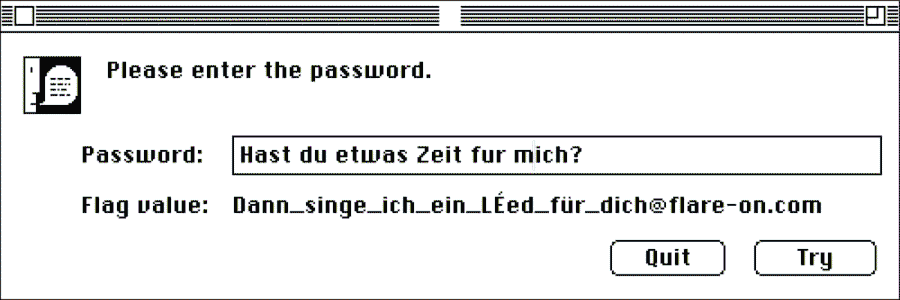

## Challenge 11

In [1]:
%flare v09/11_the_challenge_that_shall_not_be_named.7z

09.150 MB 4be357460889b0a692758973d803beca3aab18a17a7be7080c4f1b34b1c036b9 11.exe


I consider this the second hardest challenge. After inspecting some strings of `11.exe`, it turns out to be a PyInstaller executable. It is often a good idea to use refinery's [xtpyi][] unit with the `-u` flag to extract only what is likely user code:

[xtpyi]: https://binref.github.io/#refinery.xtpyi

In [1]:
%emit 11.exe | xtpyi -ul

pyi_rth_subprocess.pyc
pyi_rth_inspect.pyc
11.pyc


In [1]:
%emit 11.exe | xtpyi -cu 11.py | peek -dd

------------------------------------------------------------------------------------------------------------------------
01.979 kB; 54.52% entropy; Python script, ASCII text executable, with very long lines
---------------------------------------------------------------------------------------------------------------[utf8]---
from pytransform import pyarmor
pyarmor(__name__, __file__, b'PYARMOR\x00\x00\x03\x07\x00B\r\r\n\t0\xe0\x02\x01\x00\x00\x00\x01\x00\x00\x00@\x00\x00\x00
a\x02\x00\x00\x0b\x00\x00x\xa7\xf5\x80\x15\x8c\x1f\x90\xbb\x16Xu\x86\x9d\xbb\xbd\x8d\x00\x00\x00\x00\x00\x00\x00\x0054$\
xf1\xeb,\nY\xa9\x9b\xa5\xb3\xba\xdc\xd97\xba\x13\x0b\x89 \xd2\x14\xa7\xccH0\x9b)\xd4\x0f\xfb\xe4`\xbd\xcf\xa28\xfc\xf1\x
08\x87w\x1a\xfb%+\xc1\xbe\x8b\xc0]8h\x1f\x88\xa6CB>*\xdd\xf6\xec\xf5\xe30\xf9\x856\xfa\xd9P\xc8C\xc1\xbdm\xca&\x81\xa9\x
fb\x07HE\x1b\x00\x9e\x00a\x0c\xf2\xd0\x87\x0c<\xf8\xddZf\xf1,\x84\xce\r\x14*s\x11\x82\x88\x8d\xa7\x00k\xd9s\xae\xd3\xfc\
x16v\x0f\xb9\xd1\xd3\xd02\xecQ\x9a\

The main Python script has been protected with [PyArmor][]. Naturally, I first did a quick Google search and ran a few "deobufscators" on the file, but they were as crappy as they come and none of them worked. I felt little motivation to dig through shitty code to figure out what they were doing and how it might or might not work on this sample, so instead I decided to just approach it as I would without additional context. The main script imports a module called `pytransform`, that has to be included in the installer archive, let's have a quick look:

[PyArmor]: https://pyarmor.dashingsoft.com/

In [1]:
%emit 11.exe | xtpyi *pytransform* -l

pytransform.pyd


In [1]:
%emit 11.exe | xtpyi pytransform.pyd [| dump -t {path} ]| peek -m

------------------------------------------------------------------------------------------------------------------------
  entropy = 88.68%
    magic = PE32+ executable (DLL) (console) x86-64 (stripped to external PDB), for MS Windows
     size = 01.086 MB
------------------------------------------------------------------------------------------------------------------------
000000000: 4D 5A 90 00 03 00 00 00 04 00 00 00 FF FF 00 00 B8 00 00 00 00 00 00 00 40 00 00  MZ......................@..
00000001B: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00  ...........................
000000036: 00 00 00 00 00 00 80 00 00 00 0E 1F BA 0E 00 B4 09 CD 21 B8 01 4C CD 21 54 68 69  ..................!..L.!Thi
000000051: 73 20 70 72 6F 67 72 61 6D 20 63 61 6E 6E 6F 74 20 62 65 20 72 75 6E 20 69 6E 20  s.program.cannot.be.run.in.
00000006C: 44 4F 53 20 6D 6F 64 65 2E 0D 0D 0A 24 00 00 00 00 00 00 00 50 45 00 00 64 86 0B  DOS.mode....$.......PE..d..
000000087: 00 00 

Alright, so the PyArmor module is written in CPython - not a big surprise. It's a 64bit executable, so I used [IDA Free][] again to reverse engineer it. In the `.data` section at `0x6D6833C0`, you can find the table of functions that this Python module exports, including their names and descriptions. We are interested in the `pyarmor` function which is implemented at `0x6D605C30`. It quickly becomes apparent that the call at `0x6D605DD2` to the function at `0x6D6052E0` implements decryption and evaluation of the armored code. After reverse engineering it for a bit, the following code portion is of particular interest:
```c
DECRYPT_ARMORED_CODE:
  Offset = (unsigned int)Armored->CodeOffset;
  CodePtr = (BYTE *)&Armored->magic_PYARMOR[Offset];

  if ( Mode == 2 )
  {
    IV1 = Armored->IV1;
    ENCRYPTION_KEY[0] = KEYDATA.key[0] ^ Armored->IV0;
    IV2 = Armored->IV2;
    ENCRYPTION_KEY[1] = KEYDATA.key[1] ^ (IV1 - 15138);
    IV2 += 32815;
    IV3 = Armored->IV3;
    ENCRYPTION_KEY[2] = KEYDATA.key[2] ^ IV2;
    ENCRYPTION_KEY[3] = KEYDATA.key[3] ^ (IV3 + 9498);

    if ( lc::gcm_init(&GCM, CIPHER_AES, (BYTE *)ENCRYPTION_KEY, 0x10u)
      || lc::gcm_add_iv(&GCM, &Armored->IV0, 0xCu)
      || lc::gcm_process(&GCM, CodePtr, Armored->CodeSize, CodePtr, 1) )
    {
      return 5;
    }
    FinalCode = uc::ConstructFinalCodeFromDecryptedBody(
                  Armored->field_14,
                  Armored->field_24,
                  CodePtr,
                  Armored->CodeSize);
  }
```
Based on these calls, PyArmor decrypts the input data using AES in GCM mode. All we really need now is the key and initialization vector. The latter is stored in the armored byte array itself, and the key is derived from the IV using four DWORD fields in a global `KEYDATA` structure. Unfortunately, I was unable to easily figure out the values in `KEYDATA`, but I was in a rush to finish the challenge and did something I am not proud of - I used _dynamic analysis_:

1. Figure out that this PyInstaller uses Python 3.7
2. Install Python 3.7
3. Unpack entire PyInstaller archive
4. Run python interpreter in unpacked directory
5. Execute the command `import pytransform`
6. Attach a debugger
7. Go to the memory location that holds `KEYDATA`
8. Profit

With the extracted `KEYDATA` structure, it was easy to write a small Python script to compute the correct key and iv:

[IDA Free]: https://hex-rays.com/ida-free/

In [1]:
import struct
armored = bytes.fromhex(
    '505941524D4F520000030700420D0D0A0930E002010000000100000040000000610200000B000078'
    'A7F580158C1F90BB165875869DBBBD8D0000000000000000353424F1EB2C0A59A99BA5B3BADCD937'
    'BA130B8920D214A7CC48309B29D40FFBE460BDCFA238FCF10887771AFB252BC1BE8BC05D38681F88'
    'A643423E2ADDF6ECF5E330F98536FAD950C843C1BD6DCA2681A9FB0748451B009E00610CF2D0870C'
    '3CF8DD5A66F12C84CE0D142A731182888DA7006BD973AED3FC16760FB9D1D3D032EC519AD7614CDF'
    'C17E75CA8AD4786BDE03303BB251C824DD51D34A6AD155CC56D103A9BF9FEDE6386EAC26D6370CFD'
    'C65E0EB43007977CABAD42633C540B20642494F9904F710237E4F2ECC9BCFA4C37644E839658ABF7'
    '18ADFCF79932871DE8709743D4442E1B3B465F209174094D15350CB99FD0572043196F7A342E9938'
    'E7A998D4D29F954891F2601CFAA42CA9643F646179C4F3CBC872F797D175FEEC91C1E656A36A0FB9'
    'D5A161D5178B21C47B41B27485FE88FF614F05C5AC67ED3B5DB9DD7F53EFE446F9220CD91AB6882D'
    '5920DDEAC9F13E3ABF5D5BDF5B07B9E240EE71F9486FC3C47344CDCC8A117471F63BE9847F62E9F4'
    '7480E46C295FEA51108F5E2DC511E78478E72DB2155B35B0DC6B1A77680D3B9B79141AE03ABD9034'
    'A2FA705BE09F6E337F6B3B336EF8E325C674BF7C129A1BE2F14310BEEEE72E983E6BB972F99C4E38'
    'AEC08B410FBB8DF404B0012C05AAC50DCE912798C6D3591BD155D3D7647C7B49184A47A633D62772'
    'CF2137177164B77C1F7F17B4A8B9A8DA7A0267C72B5D4610186C0C9167D0651FE4A637B2BA9FEFBA'
    'C75B335F1243E9F4738771A3ECA0CC06F49FE1B3E65293F2D53769F896B378A775457712448CC658'
    '6B646659E04A324EBF856F8E817C43A9312379D975F1D14243CC7DE83B3F125316'
)
secret = bytes.fromhex(
    '09DE652CEC799C7638B31FF0469F02A55EF57E21982C2AF300519CFBE42DC95256A8FCD4F3126CFC'
    'BAB1AFB2AA67027561AB8C9AB20B05D273651C601B590E7E77C158FC7154C6D3ACEB61C000000000'
)
seed_bytes = secret[0x26:][:0x10]
seed_values = struct.unpack('<IIII', secret[0x26:][:0x10])
iv_bytes = armored[0x28:][:0x10]
iv_values = struct.unpack('<IIII', iv_bytes)
key_values = [
    (seed_values[0] ^ (iv_values[0] - 0)),
    (seed_values[1] ^ (iv_values[1] - 15138)),
    (seed_values[2] ^ (iv_values[2] + 32815)),
    (seed_values[3] ^ (iv_values[3] + 9498))
]
key_bytes = struct.pack('<IIII', *key_values)

print('key:', key_bytes.hex())
print(' iv:', iv_bytes[:12].hex())

key: cb093aa4c55625dc47ad142d3b7a0f86
 iv: a7f580158c1f90bb16587586


And then it is just a matter of popping those into refinery:

In [1]:
%%emit 11.exe 
    | xtpyi -c 11.py
    | carve -sd string
    | snip 64:
    | aes -r -m=gcm --iv=h:a7f580158c1f90bb16587586 h:cb093aa4c55625dc47ad142d3b7a0f86
    | rex [!-~]+@flare-on.com

Pyth0n_Prot3ction_tuRn3d_Up_t0_11@flare-on.com
